# Natural Gas Dataset
The natural gas dataset contains 834 observations of various

In [4]:
# Import libraries
import numpy as np
from numpy import genfromtxt
from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt
from numpy import linalg as lin

# Import data
my_data = genfromtxt('../Data/natgas.data.csv', delimiter=',',dtype='f8')
my_data = my_data[1:,]

## Dataset Features

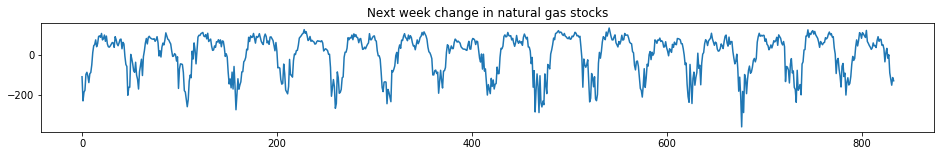

In [2]:
plt.figure(figsize=(16, 2))
plt.plot(my_data[:,9])
plt.title('Next week change in natural gas stocks')
plt.show()

Since the variable of interest is the week-to-week change in natural gas stocks, it also makes sense to include the current stock of natural gas as a feature variable. Also included in the data set is the 

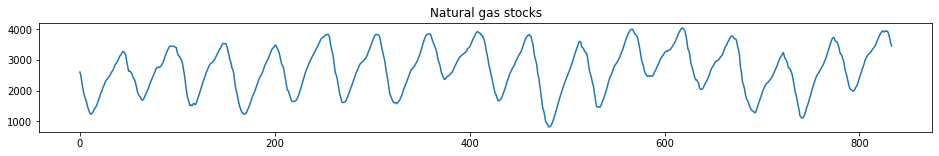

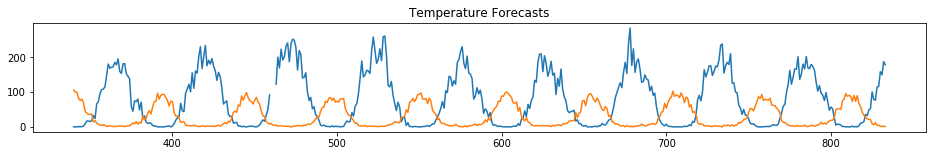

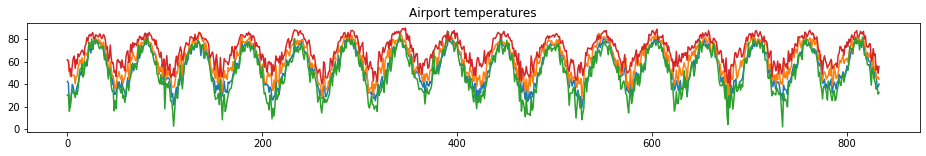

In [3]:
plt.figure(figsize=(16, 2))
plt.plot(my_data[:,1])
plt.title('Natural gas stocks')
plt.show()

plt.figure(figsize=(16, 2))
plt.plot(my_data[:,2:4])
plt.title('Temperature Forecasts')
plt.show()

plt.figure(figsize=(16, 2))
plt.plot(my_data[:,4:8])
plt.title('Airport temperatures')
plt.show()